# Vine Copula Auto-encoder

This notebook presents a vine copula auto-encoder ([paper](https://arxiv.org/abs/1906.05423)) for trajectory generation.

The basic idea is to learn the distribution in the latent space of a pre-trained auto-encoder using a vine copula.
Sampling from the vine to feed the auto-encoder's decoder will produce new trajectories.

In [1]:
import altair as alt

from deep_traffic_generation.tcvae import TCVAE
from deep_traffic_generation.core.datasets import TrafficDataset

from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

import pyvinecopulib as pv

import matplotlib.pyplot as plt
import numpy as np

from traffic.core.projection import EuroPP

import torch

from deep_traffic_generation.core.utils import traffic_from_data

import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(42)
np.random.seed(42)

Data Loading

In [2]:
dataset = TrafficDataset.from_file(
    "../deep_traffic_generation/data/traffic_15.pkl",
    features=["track", "groundspeed", "altitude", "timedelta"],
    scaler=MinMaxScaler(feature_range=(-1,1)),
    shape="image",
    info_params={"features": ["latitude", "longitude"], "index": -1},
)
dataset

Dataset TrafficDataset
    Number of datapoints: 3968
    MinMaxScaler(feature_range=(-1, 1))

Model Loading

In [3]:
model = TCVAE.load_from_checkpoint(
    "../deep_traffic_generation/lightning_logs/tcvae/version_0/checkpoints/epoch=1988-step=5966.ckpt",
    hparams_file="../deep_traffic_generation/lightning_logs/tcvae/version_0/hparams.yaml",
    dataset_params=dataset.parameters,
)
model.eval()

TCVAE(
  (encoder): Sequential(
    (0): TCN(
      (network): Sequential(
        (0): ResidualBlock(
          (tmp_block1): TemporalBlock(
            (conv): Conv1d(4, 16, kernel_size=(16,), stride=(1,))
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (tmp_block2): TemporalBlock(
            (conv): Conv1d(16, 16, kernel_size=(16,), stride=(1,))
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (downsample): Conv1d(4, 16, kernel_size=(1,), stride=(1,))
        )
        (1): ResidualBlock(
          (tmp_block1): TemporalBlock(
            (conv): Conv1d(16, 16, kernel_size=(16,), stride=(1,), dilation=(2,))
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (tmp_block2): TemporalBlock(
            (conv): Conv1d(16, 16, kernel_size=(16,), stride=(1,), dilation=(2,))
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (2): ResidualBlock(
          (tmp_block1): TemporalBlock(


Compute representation in latent space for every trajectories

In [4]:
h = model.encoder(dataset.data)
q = model.lsr(h)
z = q.rsample()
x = z.detach().cpu().numpy()
# z_scale = np.exp(z_scale.detach().cpu().numpy() / 2)
x.shape

(3968, 32)

### Reconstruction

In [5]:
original, info = dataset[0]
_, _, reconstruction = model(original.unsqueeze(0))

data = torch.cat((original.unsqueeze(0).transpose(1, 2), reconstruction.detach().transpose(1, 2)))
data.size()

torch.Size([2, 200, 4])

In [6]:
data = data.view((data.shape[0], -1))
data = dataset.scaler.inverse_transform(data)
data.shape

(2, 800)

In [7]:
info = info.repeat(2, 1)
info.size()

torch.Size([2, 2])

In [8]:
# add latitude longitude info
data = np.concatenate((info.numpy(), data), axis=1)
print(data.shape)
builder = model.get_builder(data.shape[0], 200)
features = [
    "track" if "track" in f else f for f in model.hparams.features
]
traffic = traffic_from_data(
    data, features, model.dataset_params["info_params"]["features"], builder=builder
)
traffic

(2, 802)


,count
flight_id,
TRAJ_0,200
TRAJ_1,200


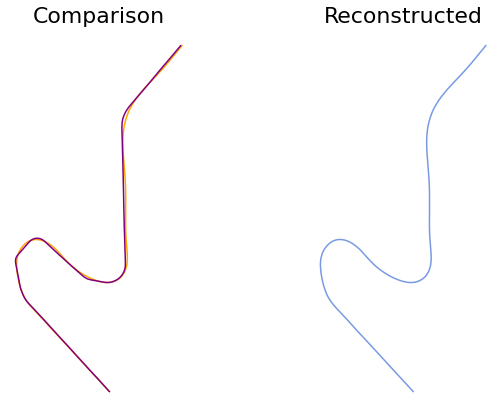

In [9]:
with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection=EuroPP()))
    ax[0].set_title("Comparison")
    traffic[1].plot(ax[0], c="orange", label="reconstructed")
    traffic[0].plot(ax[0], c="purple", label="original")
    ax[1].set_title("Reconstructed")
    traffic[1].plot(ax[1])

    plt.show()

### Generation

Transform copula data using the empirical distribution

In [10]:
u = pv.to_pseudo_obs(x)

Fit a vine

In [11]:
controls = pv.FitControlsVinecop(
    num_threads=4,
)
vine = pv.Vinecop(data=u, controls=controls)
vine

<pyvinecopulib.Vinecop>
** Tree: 0
22,3 <-> Student, parameters = 0.118361
 6.72821
25,10 <-> Student, parameters = 0.0955422
  7.80576
21,17 <-> BB7 270°, parameters =   1.06966
0.0897945
17,26 <-> Student, parameters = -0.138826
   14.455
15,3 <-> Student, parameters = 0.0826457
  7.17801
31,14 <-> Student, parameters = -0.106044
  12.4779
3,9 <-> Student, parameters = 0.131406
 9.06582
30,14 <-> Student, parameters = -0.114963
  13.1375
6,10 <-> Student, parameters = -0.103395
  6.93588
14,23 <-> Gumbel 180°, parameters = 1.09688
9,10 <-> Student, parameters = 0.109526
 7.54911
8,23 <-> Student, parameters = -0.160368
  8.93638
10,23 <-> Student, parameters = 0.224423
 14.7445
29,1 <-> Student, parameters = 0.162929
 6.36045
1,28 <-> Gumbel, parameters = 1.09999
2,4 <-> BB7 270°, parameters =    1.0679
0.0976814
4,32 <-> Student, parameters = -0.104024
  6.93419
28,32 <-> Student, parameters = 0.165192
 7.81354
19,7 <-> Student, parameters = 0.153958
 21.7816
11,26 <-> Frank, parame

Sample from the copula

In [12]:
u_sim = vine.simulate(n=100, seeds=[42])

Transform back simulations to the original scale

In [13]:
x_sim = np.asarray([np.quantile(x[:, i], u_sim[:, i]) for i in range(0, 32)])
x_sim = x_sim.transpose(1, 0)
x_sim.shape

(100, 32)

In [14]:
encodings = np.concatenate((x, x_sim), axis=0)
encodings.shape

(4068, 32)

In [15]:
z_embedded = TSNE(n_components=2).fit_transform(encodings)
z_embedded.shape

(4068, 2)

Plot embeddings (blue=original, red=sampled)

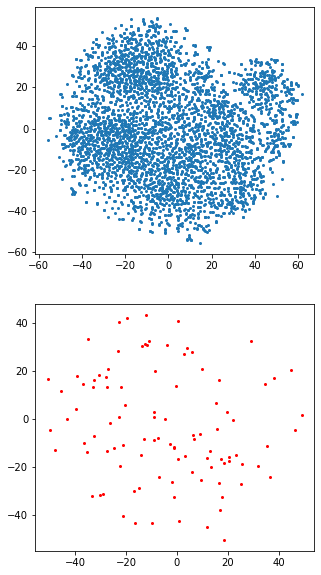

In [16]:
fig, ax = plt.subplots(2, figsize=(5, 10))
ax[0].scatter(z_embedded[:3968, 0], z_embedded[:3968, 1], s=4)
ax[1].scatter(z_embedded[3968:, 0], z_embedded[3968:, 1], s=4, c='red')
plt.show()

Find closest original trajectories

In [17]:
Xg = x_sim.T
Xr = x.T
print(f"X generated: {Xg.shape}")
print(f"X real: {Xr.shape}")

X generated: (32, 100)
X real: (32, 3968)


In [18]:
diff = (Xg[np.newaxis,...] - Xr[np.newaxis,...].T)
D = np.sqrt((diff**2).sum(1)).T
originals_idx = np.argmin(D, axis=1)

In [19]:
originals, info = dataset[originals_idx]
originals = torch.transpose(originals, 1, 2)
originals.size()

torch.Size([100, 200, 4])

In [20]:
data = originals.detach()
data = data.reshape((data.shape[0], -1))
data = dataset.scaler.inverse_transform(data)

In [21]:
data = np.concatenate((info, data), axis=1)
builder = model.get_builder(data.shape[0], dataset.seq_len)
features = [
    "track" if "track" in f else f for f in model.hparams.features
]
traffic_original = traffic_from_data(
    data, features, model.dataset_params["info_params"]["features"], builder=builder
)

if "track" not in traffic_original.data.columns:
    traffic_original = traffic_original.cumulative_distance().eval(desc="")

traffic_original

,count
flight_id,
TRAJ_0,200
TRAJ_66,200
TRAJ_75,200
TRAJ_74,200
TRAJ_73,200
TRAJ_72,200
TRAJ_71,200
TRAJ_70,200
TRAJ_7,200


Decode generated samples

In [22]:
outputs = model.decoder(torch.Tensor(x_sim))
outputs = torch.transpose(outputs, 1, 2)
outputs.size()

torch.Size([100, 200, 4])

In [23]:
data = outputs.detach().numpy()
data = data.reshape((data.shape[0], -1))
data = dataset.scaler.inverse_transform(data)

In [24]:
# add latitude longitude info
# data = data.reshape((10, -1))
data = np.concatenate((info, data), axis=1)
builder = model.get_builder(data.shape[0], dataset.seq_len)
features = [
    "track" if "track" in f else f for f in model.hparams.features
]
t_gen = traffic_from_data(
    data, features, model.dataset_params["info_params"]["features"], builder=builder
)

if "track" not in t_gen.data.columns:
    t_gen = (
        t_gen
        .cumulative_distance()
        .rename(columns=dict(compute_gs="groundspeed", compute_track="track"))
        .eval(desc="")
    )

t_gen

,count
flight_id,
TRAJ_0,200
TRAJ_66,200
TRAJ_75,200
TRAJ_74,200
TRAJ_73,200
TRAJ_72,200
TRAJ_71,200
TRAJ_70,200
TRAJ_7,200


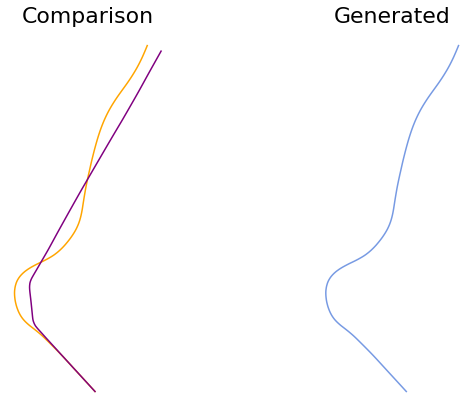

In [25]:
flight_id = 20
generated = t_gen[f"TRAJ_{flight_id}"]
original = traffic_original[f"TRAJ_{flight_id}"]
    
with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection=EuroPP()))
    ax[0].set_title("Comparison")
    generated.plot(ax[0], c="orange", label="generated")
    original.plot(ax[0], c="purple", label="closest original")
    ax[1].set_title("Generated")
    generated.plot(ax[1])

    plt.show()

In [26]:
generated.chart().encode(alt.Y("track"), alt.X("timestamp"), alt.Color("flight_id"))

alt.Chart(...)

In [27]:
generated.chart().encode(alt.Y("groundspeed"), alt.X("timestamp"), alt.Color("flight_id"))

alt.Chart(...)

In [28]:
generated.chart().encode(alt.Y("altitude"), alt.X("timestamp"), alt.Color("flight_id"))

alt.Chart(...)

Save generated trajectories into csv file

In [29]:
t_gen.to_csv("./outputs/vcae_gen.csv")